# Time Series Forecast

Project aims to
- Learn how to create a Time Series Forecast
- Focus on ARIMA (Autoregressive Integrated Moving Average) models

## Importing modules

- pandas: dedicated library for handling Time Series objects.
- numpy: general-purpose array-processing package.
- matplotlib: plotting library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Loading data set

The data contains a particular month and number of passengers travelling in that month.

In [4]:
data = pd.read_csv('Air_Passengers.csv')

print('Data:')
print(data.head())

print('\nData Types:')
print(data.dtypes)

Data:
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

Data Types:
Month          object
#Passengers     int64
dtype: object


## convert month column into datetime type

As the data types are 'object' and 'int', so 'data' is still not read as a Time Series object. So to read the data as a time series, we we pass special arguments to read_csv()

- parse_dates: Specify the column which contain the date-time information.
- index_col: Tells pandas to use the ‘some_column_name’ column as index.
- date_parser: Specify the function which converts an input string into date-time variable.

In [5]:
date = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('Air_Passengers.csv', parse_dates=['Month'], index_col='Month', date_parser=date)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


**Now the data has time object as index**

In [6]:
# cross-checking data-types
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [7]:
# convert column into series object
time_series = data["#Passengers"]
time_series.head(12)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

## Plot the Time Series data

- It is clear that there is an overall increasing trend in the data along with some seasonal variations. 

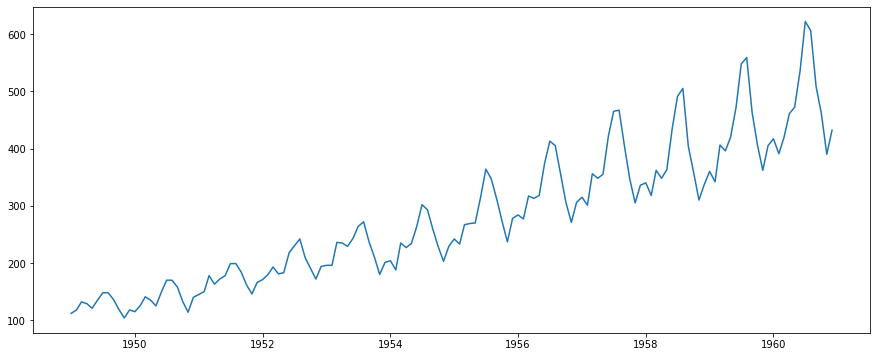

In [8]:
plt.plot(time_series)

## Check Stationary

A time series is said to be stationary if its **statistical properties** like mean and variance does not change over time i.e., remain constant over time. It can be said that if a time-series has a particular behaviour over time, then there is high probability that it will follow the same in future.

For a time series to be stationary it should have constant statistical properties over time, ie. the following:
- mean
- variance
- auto-covariance

We check stationary using following:
1. Rolling Statistics: Plot moving average and moving standard deviation and see if it varies with time.

In [9]:
# function for rolling statistics
# rolling window = 12 months (1 year)
def rolling_statistics_test(time_series):
    
    # rolling average
    rolling_mean = time_series.rolling(window = 12, center = False).mean()
    
    # rolling standard-deviation
    rolling_std = time_series.rolling(window = 12, center = False).std()
    
    # plot rolling statistics
    
    # original time series
    plt.plot(time_series, color="blue", label="origin")
    
    # rolling average
    plt.plot(rolling_mean, color="black", label="rolling_mean")
    
    # rolling standard-deviation
    plt.plot(rolling_std, color="red", label="rolling_std")
    
    # legends
    plt.legend()
    
    # title
    plt.title('Rolling Statistics')
    
    # plot
    plt.show()

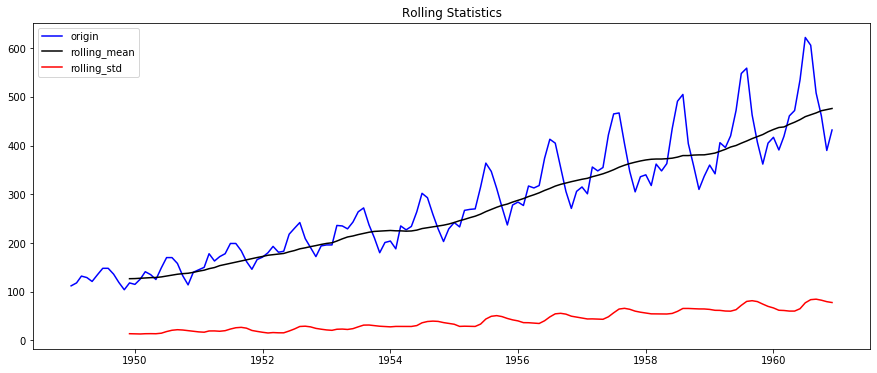

In [10]:
# rolling statistics on time series data
rolling_statistics_test(time_series)

- Variations in standard-deviation is small
- Mean is increasing with time

Hence this time-series is not a stationary series.

## Making a Time Series Stationary

Stationary assumption is taken in many models, almost none of practical time series are stationary. So there are ways to make series stationary.

Note: It's is really difficult to make a time-series perfectly stationary, we try to take it as close as possible.

Major reasons behind non-stationary time series:
1. Trend: Varying mean over time.
2. Sesonal Changes: Variations at specific time-frames.

For forecasting on non-stationary time-series
- We estimate the trend and sesonality in the series
- Remove those from the series to get a stationary series.
- Then implement statistical forecasting on this series
- Converting final forecasted values into original scale by applying trend and sesonality constraints

## Eliminating Trend & Seasonality

Certain **transformations** can be used.
In original series, we see there is a positive trend, so we need to penalize higher values more than smaller values.

Taking **log transformation** for simlicity.

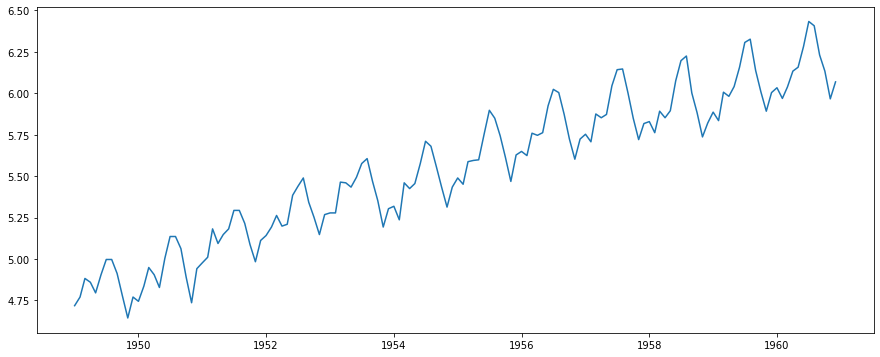

In [11]:
# stabilizing variance with log transformation
time_series_log = np.log(time_series)
plt.plot(time_series_log)

We can use following techniques to estimate this trend and remove it from the series.
- Aggregation: taking average for time period (monthly/weekly).
- Smoothing: taking rolling averages.
- Polynomial Fitting: fit a regression model

These techniques don't work in all cases, particularly the ones with high sesonality. So, some effective alternatives are:

1. Differencing: taking difference with particular time lag.
2. Decomposition: modelling both trend and sesonality & removing them from model.

### Differencing

Take the difference of the observation at a particular instant with that the previous instant.

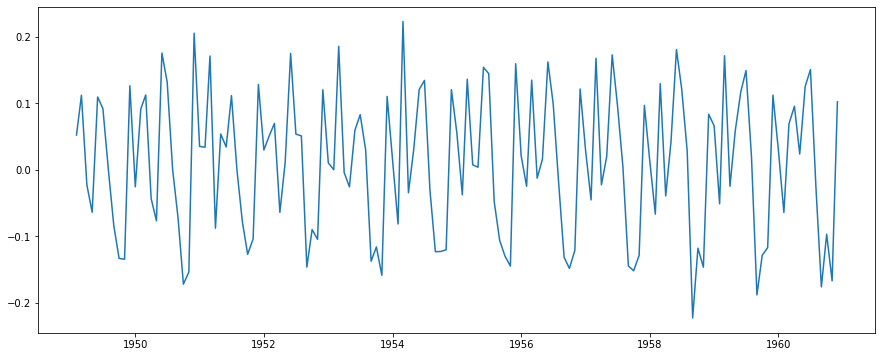

In [12]:
# First order differencing
time_series_log_diff = time_series_log - time_series_log.shift()
plt.plot(time_series_log_diff)

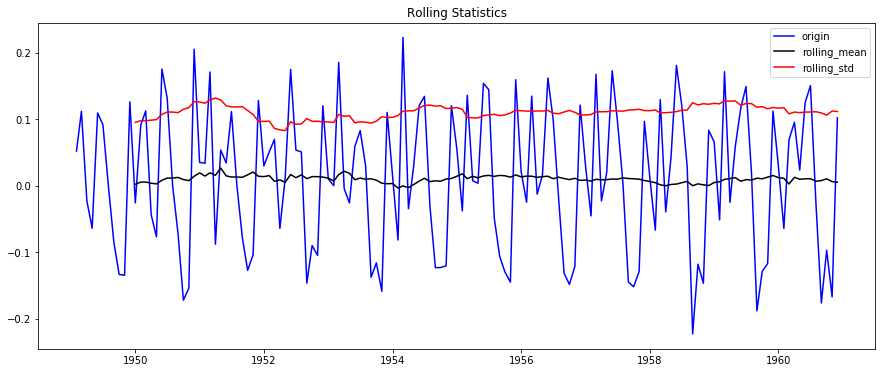

In [13]:
# plot time series

time_series_log_diff.dropna(inplace=True)
rolling_statistics_test(time_series_log_diff)

### Decompositiong

Model trend & sesonality separately & return the remaining part of the series.

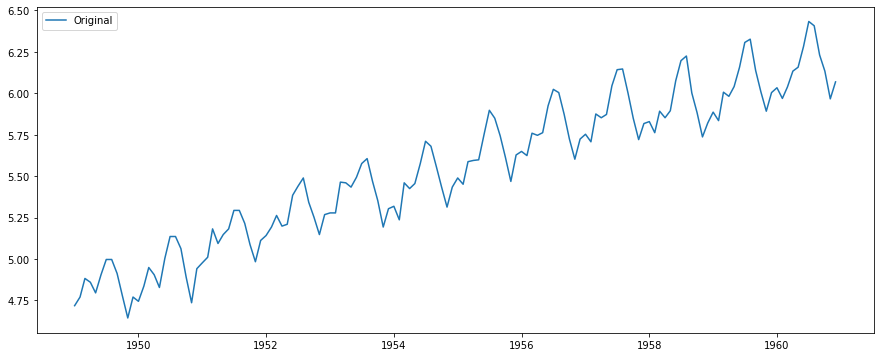

In [14]:
plt.plot(time_series_log, label='Original')
plt.legend(loc='upper left')

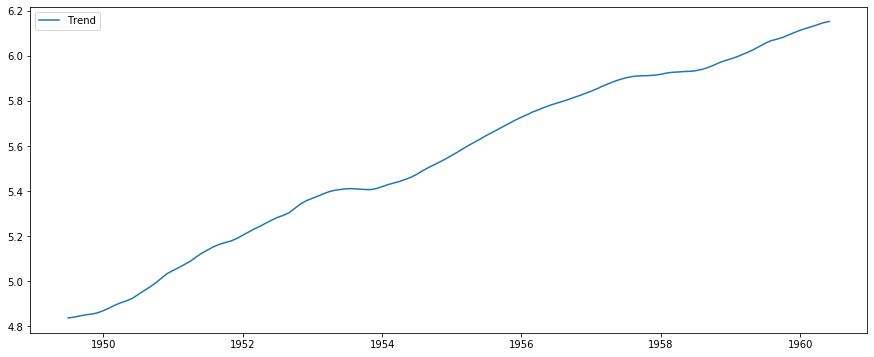

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(time_series_log)

trend = decomposition.trend

plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

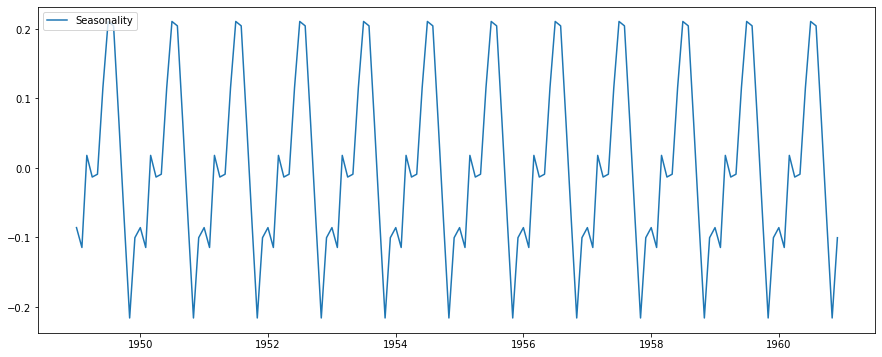

In [16]:
seasonal = decomposition.seasonal

plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')

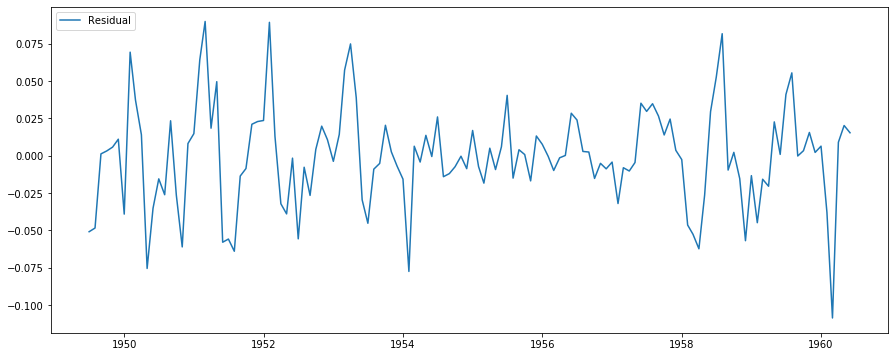

In [17]:
residual = decomposition.resid

plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

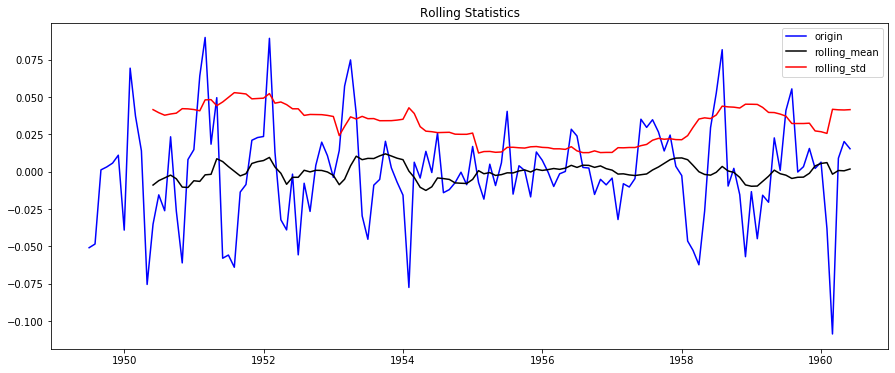

In [18]:
time_series_log_decompose = residual
time_series_log_decompose.dropna(inplace=True)
rolling_statistics_test(time_series_log_decompose)